In [1]:
import networkx as nx
from custom import load_data as cf
from networkx.algorithms import bipartite
from nxviz import CircosPlot
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Introduction

Bipartite graphs are graphs that have two (bi-) partitions (-partite) of nodes. Nodes within each partition are not allowed to be connected to one another; rather, they can only be connected to nodes in the other partition.

Bipartite graphs can be useful for modelling relations between two sets of entities. We will explore the construction and analysis of bipartite graphs here.

![bipartite graph](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e8/Simple-bipartite-graph.svg/600px-Simple-bipartite-graph.svg.png)

Let's load a [crime data](http://konect.uni-koblenz.de/networks/moreno_crime) bipartite graph and quickly explore it.

> This bipartite network contains persons who appeared in at least one crime case as either a suspect, a victim, a witness or both a suspect and victim at the same time. A left node represents a person and a right node represents a crime. An edge between two nodes shows that the left node was involved in the crime represented by the right node.

In [2]:
G = cf.load_crime_network()
G.edges(data=True)[0:5]

[('p1', 'c1', {'role': 'Suspect'}),
 ('p1', 'c2', {'role': 'Victim'}),
 ('p1', 'c3', {'role': 'Victim'}),
 ('p1', 'c4', {'role': 'Suspect'}),
 ('c1', 'p756', {'role': 'Suspect'})]

In [3]:
G.nodes(data=True)[0:10]

[('p1', {'bipartite': 'person', 'gender': 1}),
 ('c1', {'bipartite': 'crime'}),
 ('c2', {'bipartite': 'crime'}),
 ('c3', {'bipartite': 'crime'}),
 ('c4', {'bipartite': 'crime'}),
 ('p2', {'bipartite': 'person', 'gender': 1}),
 ('c5', {'bipartite': 'crime'}),
 ('c6', {'bipartite': 'crime'}),
 ('c7', {'bipartite': 'crime'}),
 ('c8', {'bipartite': 'crime'})]

## Projections

Bipartite graphs can be projected down to one of the projections. For example, we can generate a person-person graph from the person-crime graph, by declaring that two nodes that share a crime node are in fact joined by an edge.

![bipartite graph](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e8/Simple-bipartite-graph.svg/600px-Simple-bipartite-graph.svg.png)

### Exercise

Find the bipartite projection function in the NetworkX `bipartite` module [docs](https://networkx.github.io/documentation/networkx-1.10/reference/algorithms.bipartite.html), and use it to obtain the `unipartite` projection of the bipartite graph. (5 min.)

In [4]:
person_nodes = [n for n in G.nodes() if G.node[n]['bipartite'] == 'person']
pG = bipartite.projection.projected_graph(G, person_nodes)
pG.nodes(data=True)[0:5]

[('p1', {'bipartite': 'person', 'gender': 1}),
 ('p2', {'bipartite': 'person', 'gender': 1}),
 ('p3', {'bipartite': 'person', 'gender': 1}),
 ('p4', {'bipartite': 'person', 'gender': 1}),
 ('p5', {'bipartite': 'person', 'gender': 1})]

### Exercise


Try visualizing the person-person crime network by using a Circos plot. Ensure that the nodes are grouped by gender and then by number of connections. (5 min.)

Again, recapping the Circos Plot API:

```python
c = CircosPlot(graph_object, node_color='metadata_key1', node_grouping='metadata_key2', node_order='metadat_key3')
c.draw()
plt.show()  # or plt.savefig('...')
```

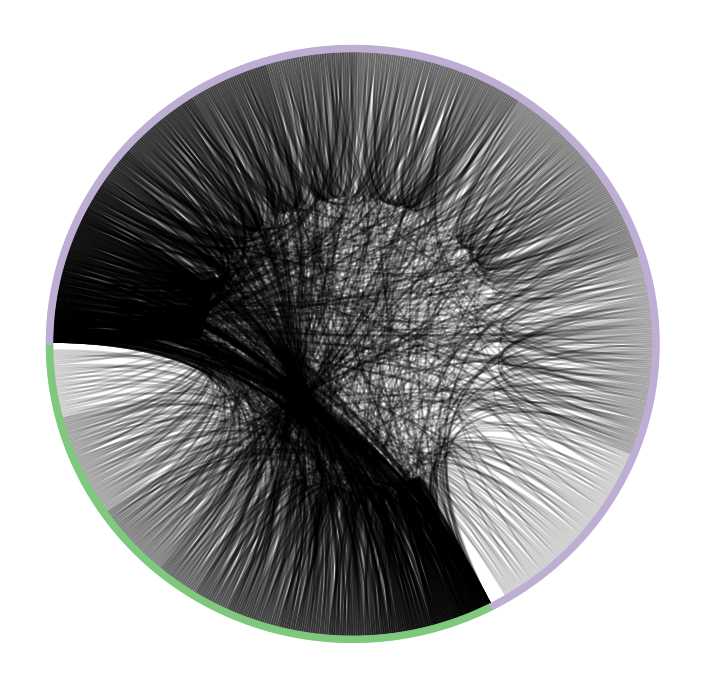

In [5]:
for n, d in pG.nodes(data=True):
    pG.node[n]['connectivity'] = len(pG.neighbors(n))
c = CircosPlot(pG, node_color='gender', node_grouping='gender', node_order='connectivity')
c.draw()
plt.savefig('images/crime-person.png', dpi=300)

### Exercise

Use a similar logic to extract crime links. (2 min.)

In [6]:
crime_nodes = [n for n in G.nodes() if G.node[n]['bipartite'] == 'crime']
cG = bipartite.projection.projected_graph(G, crime_nodes)

### Exercise

Can you plot how the crimes are connected, using a Circos plot? Try ordering it by number of connections. (5 min.)

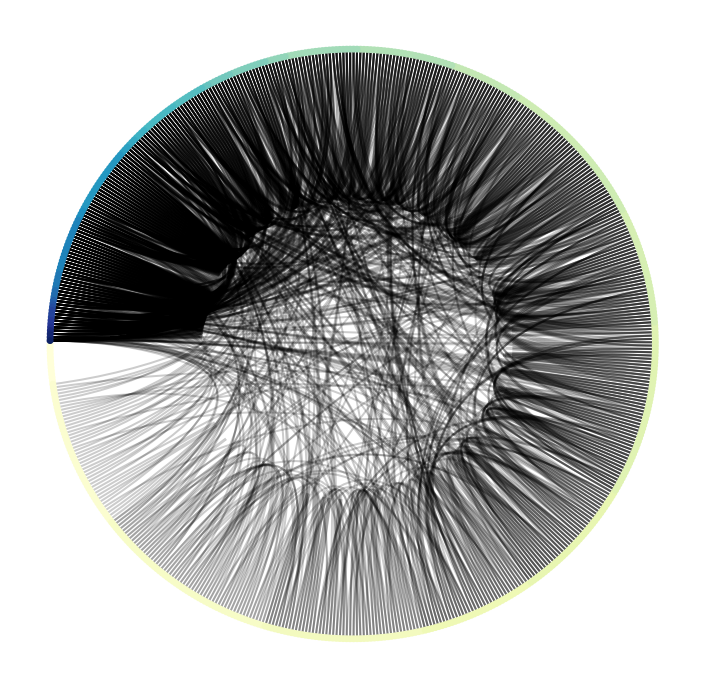

In [7]:
for n in cG.nodes():
    cG.node[n]['connectivity'] = float(len(cG.neighbors(n)))
c = CircosPlot(cG, node_order='connectivity', node_color='connectivity')
c.draw()
plt.savefig('images/crime-crime.png', dpi=300)

### Exercise

NetworkX also implements centrality measures for bipartite graphs, which allows you to obtain their metrics without first converting to a particular projection. This is useful for exploratory data analysis. 

Try the following challenges, referring to the [API documentation](https://networkx.github.io/documentation/networkx-1.9/reference/algorithms.bipartite.html) to help you:

1. Which crimes have the most number of people involved?
1. Which people are involved in the most number of crimes?

Exercise total: 5 min.

In [9]:
# Degree Centrality
bpdc = bipartite.degree_centrality(G, person_nodes)
sorted(bpdc.items(), key=lambda x: x[1], reverse=True)[0:5]

[('p815', 0.045372050816696916),
 ('p2', 0.039927404718693285),
 ('p425', 0.032667876588021776),
 ('p220', 0.0308529945553539),
 ('p56', 0.025408348457350273)]

## Bonus Lecture: Matrix Representation

Bipartite graphs have a natural matrix representation, known as the **biadjacency matrix**. Nodes on one partition are the rows, and nodes on the other partition are the columns.

NetworkX's `bipartite` module provides a function for computing the biadjacency matrix of a bipartite graph.

Let's start by looking at a toy bipartite graph, a "customer-product" purchase record graph, with 4 products and 3 customers. The matrix representation might be as follows:

In [10]:
import numpy as np
# Rows = customers, columns = products, 1 = customer purchased product, 0 = customer did not purchase product.
cp_mat = np.array([[0, 1, 0, 0],
                   [1, 0, 1, 0],
                   [0, 1, 1, 1]])

From this "bi-adjacency" matrix, one can compute the projection onto the customers, matrix multiplying the matrix with its transpose.

In [11]:
c_mat = cp_mat @ cp_mat.T  # c_mat means "customer matrix"
c_mat

array([[1, 0, 1],
       [0, 2, 1],
       [1, 1, 3]])

**Pause here and read carefully!**

What we get is the connectivity matrix of the customers, based on shared purchases. The diagonals are the degree of the customers in the original graph, i.e. the number of purchases they originally made, and the off-diagonals are the connectivity matrix, based on shared products.

To get the products matrix, we make the transposed matrix the left side of the matrix multiplication.

In [12]:
p_mat = cp_mat.T @ cp_mat  # p_mat means "product matrix"
p_mat

array([[1, 0, 1, 0],
       [0, 2, 1, 1],
       [1, 1, 2, 1],
       [0, 1, 1, 1]])

You may now try to convince yourself that the diagonals are the number of times a customer purchased that product, and the off-diagonals are the connectivity matrix of the products.

Now, let's complete the following exercises to compare the timing of `nx.bipartite.projected_graph` function to matrix multiplications.

### Exercise

Compute the biadjacency matrix of the graph G. Make the rows the "person" nodes, and the columns the "crime" nodes. (2 min.)

**Hint:** You may want to look at the [bipartite documentation](https://networkx.github.io/documentation/networkx-1.10/reference/algorithms.bipartite.html) for the `biadjacency_matrix` function.

In [16]:
mat = bipartite.biadjacency_matrix(G, row_order=sorted(person_nodes), column_order=sorted(crime_nodes))
mat

<829x551 sparse matrix of type '<class 'numpy.int64'>'
	with 1476 stored elements in Compressed Sparse Row format>

### Exercise

In the code cells below, time the computation of projection onto the **crime nodes** using matrix multiplications (1st cell) and NetworkX's `bipartite.projected_graph` function. 

In [17]:
%%timeit
mat.T @ mat

451 µs ± 29.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [18]:
%%timeit 
bipartite.projected_graph(G, crime_nodes)

14.4 ms ± 864 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Note how the matrix multiplication is much faster. The tradeoff, though, is that we lose the rich metadata that might be encoded on the nodes and edges of the graph.

### Demo

Remember how the diagonal encodes the original degree of any given node in the graph. Let's use that fact to find the node that was most connected.

In [16]:
person_projection = (mat @ mat.T)
person_projection.diagonal()
noi = np.argmax(person_projection.diagonal())  # this is the node that has the highest degree.

person_projection[noi, noi]   # the original degree in the bipartite graph.

25

In [17]:
len(G.neighbors(sorted(person_nodes)[noi]))  # original number of neighbors

25

Thus far, this is just a teaser as to what you can do with the matrix representation of a graph! I hope it's whetted your appetite for more!